In [4]:
"""
Title: Image classification with Vision Transformer
Author: Maya Seale
Date created: 2023/11/03
Last modified: 2023/11/03
Description: Implementing the Vision Transformer (ViT) model for image classification.




## Introduction

This notebook adapts Khalid Salama's implemention (https://github.com/keras-team/keras-io/blob/master/examples/vision/image_classification_with_vision_transformer.py)
which is an implementation of the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification.

Here, I test it on a smaller data set than the one it was intended for (CIFAR-100), the Monkey Images Dataset
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

"""

"\nTitle: Image classification with Vision Transformer\nAuthor: Maya Seale\nDate created: 2023/11/03\nLast modified: 2023/11/03\nDescription: Implementing the Vision Transformer (ViT) model for image classification.\n\n\n\n\n## Introduction\n\nThis notebook adapts Khalid Salama's implemention (https://github.com/keras-team/keras-io/blob/master/examples/vision/image_classification_with_vision_transformer.py) \nwhich is an implementation of the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)\nmodel by Alexey Dosovitskiy et al. for image classification.\n\nHere, I test it on a smaller data set than the one it was intended for (CIFAR-100), the Monkey Images Dataset \nThe ViT model applies the Transformer architecture with self-attention to sequences of\nimage patches, without using convolution layers.\n\n"

In [5]:
pip install -U tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 3.8 MB/s eta 0:00:00


In [6]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
import csv
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
url = "https://storage.googleapis.com/doggies-doggies/Monkeys.zip"
pathto = "/content/monkey"
path = keras.utils.get_file("Monkeys.zip",origin = url)
import zipfile
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(pathto)


573619322/573619322 [==============================] - 6s 0us/step


In [8]:
train_dir = os.path.join(pathto, 'training/training')
validation_dir = os.path.join(pathto, 'validation/validation')
train_dataset = tf.keras.utils.image_dataset_from_directory( train_dir, labels="inferred",color_mode="rgb", image_size=(72,72), batch_size= 30)

Found 1097 files belonging to 10 classes.


In [9]:

validation_dataset = tf.keras.utils.image_dataset_from_directory( validation_dir, labels="inferred",color_mode="rgb", image_size=(72,72), batch_size= 30)

Found 272 files belonging to 10 classes.


In [10]:
train_dataset.class_names = ["Mantled Howler","Patas Monkey","Bald Uakari","Japanese Macaque", "Pygmy Marmoset","White Headed Capuchin","Silvery Marmoset", "Common Squirrel Monkey", "Black Headed Night Monkey","Nilgiri Langur"]


In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=10>

In [12]:
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


In [13]:
print('Number of test batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of test batches: 37


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [15]:
train_dataset=np.array(train_dataset)
test_dataset=np.array(test_dataset)
validation_dataset=np.array(test_dataset)

In [16]:
type(train_dataset)

numpy.ndarray

In [17]:
for images, labels in train_dataset.take(-1):
    x_train = images
    y_train = labels


In [18]:
for images, labels in test_dataset.take(-1):
    x_test = images
    y_test = labels


In [19]:
for images, labels in validation_dataset.take(-1):
    x_val = images
    y_val = labels


Configure the hyperparameters

In [20]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
num_classes = 100
input_shape = (72, 72, 3)
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

Use data augmentation

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Implement Multilayer Perceptron

In [22]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [23]:
# Patch Creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [24]:
tf.compat.v1.enable_eager_execution()



In [25]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


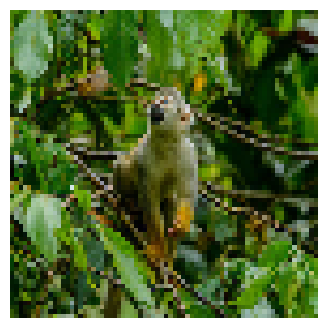

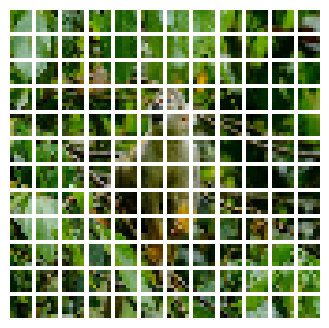

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [27]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [28]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [29]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/Users/emilyseale/Downloads/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
      validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 8.2985 - accuracy: 0.0000e+00 - top-5-accuracy: 0.0000e+00 - val_loss: 4.0469 - val_accuracy: 0.2000 - val_top-5-accuracy: 0.6000
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 4.2499 - accuracy: 0.3529 - top-5-accuracy: 0.5882 - val_loss: 5.7606 - val_accuracy: 0.3000 - val_top-5-accuracy: 0.6000
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 2.4144 - accuracy: 0.5294 - top-5-accuracy: 0.8235 - val_loss: 9.9426 - val_accuracy: 0.2333 - val_top-5-accuracy: 0.5333
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 3.9259 - accuracy: 0.4118 - top-5-accuracy: 0.8824 - val_loss: 9.5223 - val_accuracy: 0.2000 - val_top-5-accuracy: 0.6000
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 3.2043 - accuracy: 0.3529 - top-5-accuracy: 1.0000 - val_loss: 10.7707 - val_accuracy: 0.3000 - val_top-5-accuracy: 0.6000
Epoch 6/100
1/1 [============